# KPI Consensus Recommendation (7 Graph KPIs)

This notebook reads `out/kpi_summary/kpi_summary.json` and builds **one summary graph** showing the recommended battery size from each of the **7 graph KPIs**.

Decision rule used here:
- Each graph KPI contributes **1 vote** to its recommended battery size
- The **best battery** is the size with the **highest vote count**
- If several sizes are tied, the notebook picks the **smallest size** (conservative tie-break)


In [1]:
from __future__ import annotations

import json
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

KPI_JSON_PATH = Path('out/kpi_summary/kpi_summary.json')
EXPORT_FIGURE = True
FIG_OUTPUT = Path('out/kpi_images/01_graph_kpi_consensus_best_battery.png')

GRAPH_ORDER = [
    'global_energy_reduction_kwh',
    'global_energy_financial_impact_chf',
    'global_rentability_overview',
    'global_battery_utilization',
    'global_battery_status_heatmap',
    'seasonal_power_saturation_at_max_limit',
    'monthly_structural_evening_energy_undersizing_peak_period',
]

GRAPH_LABELS = {
    'global_energy_reduction_kwh': 'Global Energy Reduction',
    'global_energy_financial_impact_chf': 'Global Financial Impact',
    'global_rentability_overview': 'Global Rentability',
    'global_battery_utilization': 'Global Battery Utilization',
    'global_battery_status_heatmap': 'Global Status Heatmap',
    'seasonal_power_saturation_at_max_limit': 'Seasonal Power Saturation',
    'monthly_structural_evening_energy_undersizing_peak_period': 'Monthly Evening Undersizing',
}

def _safe_float(value):
    try:
        return float(value)
    except (TypeError, ValueError):
        return None

def _kpi_type_from_blob(kpi_blob: dict) -> str:
    name = str(kpi_blob.get('name', '')).lower()
    if 'step-delta' in name:
        return 'step_delta'
    return 'constraint_cap'

def _collect_candidate_sizes(kpi_blob: dict) -> set[float]:
    sizes = set()
    rec = kpi_blob.get('recommendation') or {}
    rec_size = _safe_float(rec.get('battery_size_kwh'))
    if rec_size is not None:
        sizes.add(round(rec_size, 2))

    for row in kpi_blob.get('evaluated_candidates') or []:
        size = _safe_float((row or {}).get('battery_size_kwh'))
        if size is not None:
            sizes.add(round(size, 2))

    for step in kpi_blob.get('steps') or []:
        for key in ('from_battery_size_kwh', 'to_battery_size_kwh'):
            size = _safe_float((step or {}).get(key))
            if size is not None:
                sizes.add(round(size, 2))
    return sizes

if not KPI_JSON_PATH.exists():
    raise FileNotFoundError(f'KPI summary JSON not found: {KPI_JSON_PATH}. Run make kpi_summary first.')

kpi_data = json.loads(KPI_JSON_PATH.read_text(encoding='utf-8'))
graph_kpis = kpi_data.get('graph_kpis') or {}

rows = []
all_sizes = set()
for group_key in GRAPH_ORDER:
    group = graph_kpis.get(group_key) or {}
    if not isinstance(group, dict) or not group:
        continue

    kpi_key = next((k for k, v in group.items() if isinstance(v, dict)), None)
    if not kpi_key:
        continue
    kpi_blob = group[kpi_key]

    rec = kpi_blob.get('recommendation') or {}
    size_kwh = _safe_float(rec.get('battery_size_kwh'))
    if size_kwh is None:
        continue
    size_kwh = round(size_kwh, 2)

    rows.append({
        'group_key': group_key,
        'kpi_key': kpi_key,
        'kpi_label': GRAPH_LABELS.get(group_key, group_key),
        'kpi_name': kpi_blob.get('name', group_key),
        'kpi_type': _kpi_type_from_blob(kpi_blob),
        'scenario': rec.get('scenario', 'unknown'),
        'battery_size_kwh': size_kwh,
    })

    all_sizes.update(_collect_candidate_sizes(kpi_blob))

df_kpi_votes = pd.DataFrame(rows)
if df_kpi_votes.empty:
    raise ValueError('No graph KPI recommendations found in kpi_summary.json')

size_order = sorted({round(float(x), 2) for x in all_sizes.union(set(df_kpi_votes['battery_size_kwh']))})
vote_counts = (
    df_kpi_votes.groupby('battery_size_kwh')
    .size()
    .reindex(size_order, fill_value=0)
    .rename('votes')
    .reset_index()
)

max_votes = int(vote_counts['votes'].max())
best_sizes = sorted(vote_counts.loc[vote_counts['votes'] == max_votes, 'battery_size_kwh'].tolist())
best_battery_kwh = float(best_sizes[0])  # conservative tie-break: smallest size among top vote count

df_kpi_votes['battery_size_kwh'] = df_kpi_votes['battery_size_kwh'].round(2)
df_kpi_votes['is_best_vote_choice'] = df_kpi_votes['battery_size_kwh'].eq(best_battery_kwh)

print(f'Loaded {len(df_kpi_votes)} graph KPI recommendations from {KPI_JSON_PATH}')
print(f'Consensus best battery (vote-based): {best_battery_kwh:.2f} kWh with {max_votes}/7 votes')
display(vote_counts)
display(df_kpi_votes[['kpi_label', 'kpi_type', 'battery_size_kwh', 'scenario']])


Loaded 7 graph KPI recommendations from out/kpi_summary/kpi_summary.json
Consensus best battery (vote-based): 17.28 kWh with 5/7 votes


,battery_size_kwh,votes
0,0.00,0
1,8.64,1
2,17.28,5
3,25.92,0
4,34.56,0
5,43.20,1


,kpi_label,kpi_type,battery_size_kwh,scenario
0,Global Energy Reduction,step_delta,17.28,Zendure2400_5760Wh
1,Global Financial Impact,step_delta,17.28,Zendure2400_5760Wh
2,Global Rentability,constraint_cap,17.28,Zendure2400_5760Wh
3,Global Battery Utilization,constraint_cap,17.28,Zendure2400_5760Wh
4,Global Status Heatmap,constraint_cap,43.20,Zendure2400_14400Wh
5,Seasonal Power Saturation,constraint_cap,8.64,Zendure2400_2880Wh
6,Monthly Evening Undersizing,constraint_cap,17.28,Zendure2400_5760Wh


Saved figure: out/kpi_images/01_graph_kpi_consensus_best_battery.png


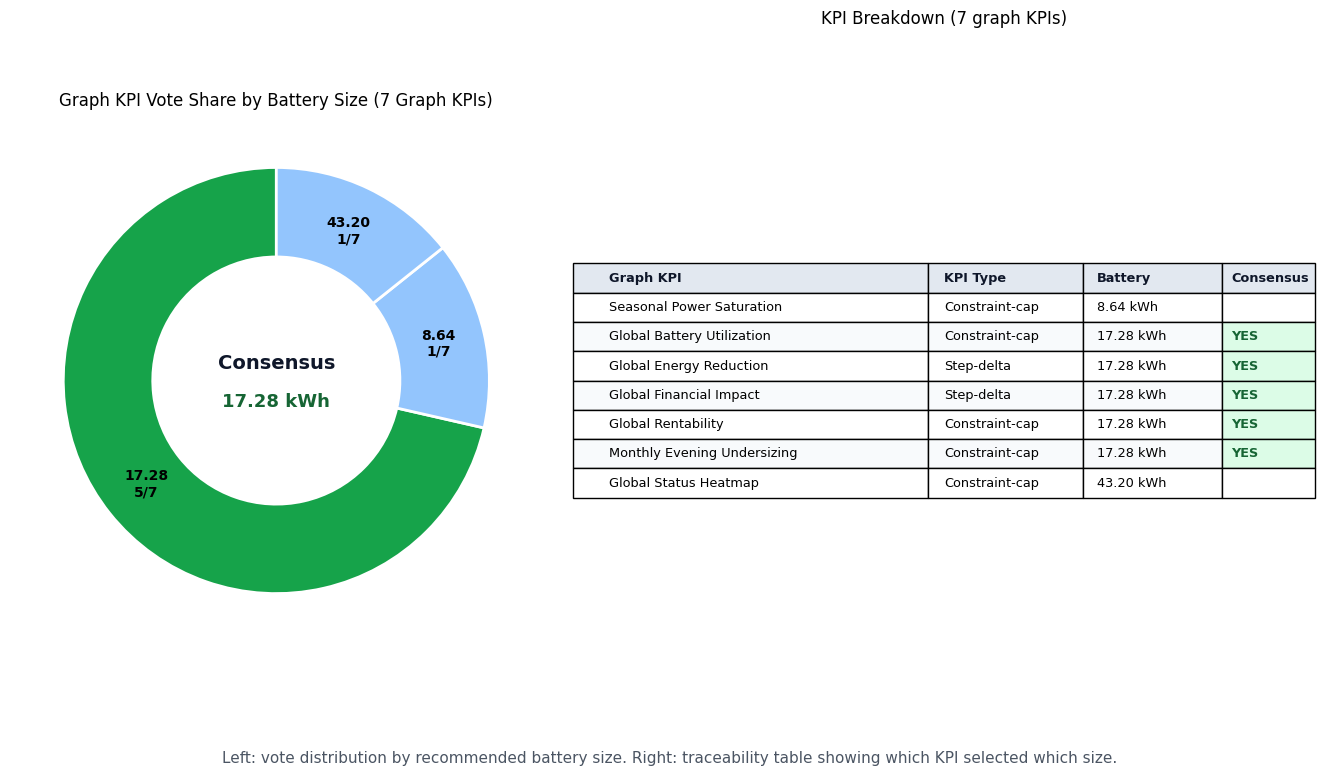

In [2]:
# Selected summary graph: Donut + breakdown table (executive summary view)
donut_df = vote_counts[vote_counts['votes'] > 0].copy().sort_values(['votes', 'battery_size_kwh'], ascending=[False, True]).reset_index(drop=True)
if donut_df.empty:
    raise ValueError('No votes available to plot.')

donut_colors = []
for size in donut_df['battery_size_kwh']:
    if float(size) == float(best_battery_kwh):
        donut_colors.append('#16a34a')
    else:
        donut_colors.append('#93c5fd')

fig = plt.figure(figsize=(13.5, 7.8))
gs = fig.add_gridspec(1, 2, width_ratios=[1.0, 1.45])
ax_pie = fig.add_subplot(gs[0, 0])
ax_tbl = fig.add_subplot(gs[0, 1])

wedges, _ = ax_pie.pie(
    donut_df['votes'],
    colors=donut_colors,
    startangle=90,
    wedgeprops=dict(width=0.42, edgecolor='white', linewidth=2),
)

for wedge, (_, row) in zip(wedges, donut_df.iterrows()):
    ang = (wedge.theta2 + wedge.theta1) / 2
    x = 0.78 * np.cos(np.deg2rad(ang))
    y = 0.78 * np.sin(np.deg2rad(ang))
    ax_pie.text(x, y, f"{row['battery_size_kwh']:.2f}\n{int(row['votes'])}/7", ha='center', va='center', fontsize=10, fontweight='bold')

ax_pie.text(0, 0.08, 'Consensus', ha='center', va='center', fontsize=14, fontweight='bold', color='#0f172a')
ax_pie.text(0, -0.10, f'{best_battery_kwh:.2f} kWh', ha='center', va='center', fontsize=13, color='#166534', fontweight='bold')
ax_pie.set_title('Graph KPI Vote Share by Battery Size (7 Graph KPIs)')

ax_tbl.axis('off')
tbl_df = (
    df_kpi_votes[['kpi_label', 'kpi_type', 'battery_size_kwh', 'scenario']]
    .sort_values(['battery_size_kwh', 'kpi_label'])
    .reset_index(drop=True)
)
tbl_df['KPI Type'] = tbl_df['kpi_type'].map({'step_delta': 'Step-delta', 'constraint_cap': 'Constraint-cap'})
tbl_df['Battery'] = tbl_df['battery_size_kwh'].map(lambda x: f'{x:.2f} kWh')
tbl_df['Consensus'] = tbl_df['battery_size_kwh'].eq(best_battery_kwh).map({True: 'YES', False: ''})
tbl_render = tbl_df[['kpi_label', 'KPI Type', 'Battery', 'Consensus']].rename(columns={'kpi_label': 'Graph KPI'})

table = ax_tbl.table(
    cellText=tbl_render.values.tolist(),
    colLabels=tbl_render.columns.tolist(),
    loc='center',
    cellLoc='left',
    colLoc='left',
    colWidths=[0.46, 0.20, 0.18, 0.12],
)
table.auto_set_font_size(False)
table.set_fontsize(9.3)
table.scale(1, 1.55)

for (r, c), cell in table.get_celld().items():
    if r == 0:
        cell.set_text_props(weight='bold', color='#0f172a')
        cell.set_facecolor('#e2e8f0')
    else:
        if r % 2 == 0:
            cell.set_facecolor('#f8fafc')
        if c == 3 and cell.get_text().get_text() == 'YES':
            cell.set_facecolor('#dcfce7')
            cell.set_text_props(color='#166534', weight='bold')

ax_tbl.set_title('KPI Breakdown (7 graph KPIs)', pad=12)

fig.text(
    0.5,
    0.015,
    'Left: vote distribution by recommended battery size. Right: traceability table showing which KPI selected which size.',
    ha='center',
    fontsize=11,
    color='#4b5563',
    wrap=True,
)

plt.tight_layout(rect=[0, 0.05, 1, 1])

if EXPORT_FIGURE:
    FIG_OUTPUT.parent.mkdir(parents=True, exist_ok=True)
    fig.savefig(FIG_OUTPUT, dpi=180, bbox_inches='tight')
    print(f'Saved figure: {FIG_OUTPUT}')

plt.show()
